# Modeling Credit Risk with Lending Club data

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC


The biggest question re this data is which features are pulled at origination time.
For the details on this, see stuff below:
- https://www.kaggle.com/datasets/wordsforthewise/lending-club/discussion/220358
- https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook

From those links above, it seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.

Notes:
Address is a key feature. Try to get it. Zip_code from address wil dramatically improve results.
And use ohe for more cat features.

### Business Problem

### Objective

### Summary of Results

In [195]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [197]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [198]:
time0 = time.time()

with open('../input/lc-800k-sample/LCLoans_141_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl', 'total_rev_hi_lim',               
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd',
 'recoveries']

df = df[features_tokeep]


df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later

df.issue_d = df.issue_d.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
#df = df[df.year_issued.isin([2018])]
    
df = df.sample(100000)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(100000, 67)

1.430438756942749

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued
0,Current,14000.0,14000.0,14000.0,60.0,18.06,355.970001,2017-11-01,debt_consolidation,Debt consolidation,w,Individual,D,D2,679.0,para leagal,6 years,RENT,60000.0,112xx,NY,5.580000,Source Verified,5.0,37.0,NaN,NaN,37.0,37.0,3.0,Oct-2007,0.0,0.0,1.0,8.0,3.0,0.0,10.0,646.0,5167.0,5167.0,26.0,7386.0,5.0,3.0,8.0,20100.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,5167.0,0.0,0.0,25.000000,100.000000,3.0,0.0,0.0,0.0,0.0,0.0,2017.0
1,Current,6000.0,6000.0,6000.0,36.0,7.02,185.320007,2019-08-01,credit_card,Credit card refinancing,w,Individual,A,A2,684.0,NaN,8 years,MORTGAGE,54000.0,775xx,TX,13.380000,Source Verified,2.0,NaN,NaN,NaN,NaN,NaN,4.0,Jan-1995,2.0,2.0,2.0,7.0,9.0,0.0,20.0,3631.0,25420.0,8727.0,50.2,2965.0,3.0,5.0,6.0,17400.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,25420.0,0.0,0.0,50.000000,100.000000,3.0,1.0,0.0,0.0,0.0,0.0,2019.0
2,Fully Paid,6000.0,6000.0,6000.0,36.0,11.80,198.720001,2018-12-01,debt_consolidation,Debt consolidation,w,Individual,B,B4,709.0,NaN,< 1 year,RENT,41800.0,041xx,ME,33.959999,Source Verified,18.0,23.0,NaN,NaN,23.0,23.0,0.0,Jun-2007,1.0,0.0,1.0,7.0,1.0,0.0,15.0,4323.0,30258.0,5646.0,58.8,2354.0,47.0,2.0,4.0,9600.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,30258.0,0.0,0.0,33.299999,86.699997,0.0,0.0,0.0,0.0,0.0,0.0,2018.0
3,Fully Paid,8000.0,8000.0,8000.0,36.0,10.16,258.739990,2013-06-01,debt_consolidation,Debt consolidation,f,Individual,B,B1,694.0,Bridgeton Board of Edu,3 years,RENT,48000.0,083xx,NJ,14.110000,Not Verified,8.0,10.0,10.0,NaN,NaN,13.0,1.0,Dec-1998,1.0,NaN,NaN,24.0,5.0,0.0,35.0,1069.0,23519.0,6428.0,15.5,22029.0,8.0,13.0,21.0,41500.0,3.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,23519.0,0.0,0.0,0.000000,85.000000,NaN,NaN,2.0,0.0,0.0,2.0,2013.0
4,Fully Paid,31300.0,31300.0,31300.0,60.0,20.80,843.260010,2013-09-01,debt_consolidation,Pay off credit cards,w,Individual,E,E1,704.0,King County Prosecutor's Office,10+ years,MORTGAGE,70000.0,980xx,WA,12.890000,Verified,29.0,NaN,NaN,NaN,NaN,NaN,0.0,Sep-1996,1.0,NaN,NaN,5.0,0.0,7.0,17.0,6237.0,31186.0,31186.0,84.3,5743.0,29.0,5.0,5.0,37000.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,31186.0,0.0,0.0,75.000000,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2013.0


In [199]:
### feature description:

f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])


73    The number of open credit lines in the borrowe...
Name: desc, dtype: object

99    The total number of credit lines currently in ...
Name: desc, dtype: object

In [200]:
# remove some very rarae loan types:

df = df[~df.purpose.isin(['educational', 'renewable_energy', 'wedding'])]
df.purpose = df.purpose.cat.remove_categories(['educational', 'renewable_energy', 'wedding'])


In [201]:
# clean time features

df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,Current,14000.0,14000.0,14000.0,60.0,18.06,355.970001,2017-11-01,debt_consolidation,Debt consolidation,w,Individual,D,D2,679.0,para leagal,6 years,RENT,60000.0,112xx,NY,5.580000,Source Verified,5.0,37.0,NaN,NaN,37.0,37.0,3.0,2007-10-01,0.0,0.0,1.0,8.0,3.0,0.0,10.0,646.0,5167.0,5167.0,26.0,7386.0,5.0,3.0,8.0,20100.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,5167.0,0.0,0.0,25.000000,100.000000,3.0,0.0,0.0,0.0,0.0,0.0,2017.0,11,2017,10.086449,0.0
1,Current,6000.0,6000.0,6000.0,36.0,7.02,185.320007,2019-08-01,credit_card,Credit card refinancing,w,Individual,A,A2,684.0,NaN,8 years,MORTGAGE,54000.0,775xx,TX,13.380000,Source Verified,2.0,NaN,NaN,NaN,NaN,NaN,4.0,1995-01-01,2.0,2.0,2.0,7.0,9.0,0.0,20.0,3631.0,25420.0,8727.0,50.2,2965.0,3.0,5.0,6.0,17400.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,25420.0,0.0,0.0,50.000000,100.000000,3.0,1.0,0.0,0.0,0.0,0.0,2019.0,8,2019,24.580929,0.0
2,Fully Paid,6000.0,6000.0,6000.0,36.0,11.80,198.720001,2018-12-01,debt_consolidation,Debt consolidation,w,Individual,B,B4,709.0,NaN,< 1 year,RENT,41800.0,041xx,ME,33.959999,Source Verified,18.0,23.0,NaN,NaN,23.0,23.0,0.0,2007-06-01,1.0,0.0,1.0,7.0,1.0,0.0,15.0,4323.0,30258.0,5646.0,58.8,2354.0,47.0,2.0,4.0,9600.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,30258.0,0.0,0.0,33.299999,86.699997,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,12,2018,11.501947,0.0
3,Fully Paid,8000.0,8000.0,8000.0,36.0,10.16,258.739990,2013-06-01,debt_consolidation,Debt consolidation,f,Individual,B,B1,694.0,Bridgeton Board of Edu,3 years,RENT,48000.0,083xx,NJ,14.110000,Not Verified,8.0,10.0,10.0,NaN,NaN,13.0,1.0,1998-12-01,1.0,NaN,NaN,24.0,5.0,0.0,35.0,1069.0,23519.0,6428.0,15.5,22029.0,8.0,13.0,21.0,41500.0,3.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,23519.0,0.0,0.0,0.000000,85.000000,NaN,NaN,2.0,0.0,0.0,2.0,2013.0,6,2013,14.499956,0.0
4,Fully Paid,31300.0,31300.0,31300.0,60.0,20.80,843.260010,2013-09-01,debt_consolidation,Pay off credit cards,w,Individual,E,E1,704.0,King County Prosecutor's Office,10+ years,MORTGAGE,70000.0,980xx,WA,12.890000,Verified,29.0,NaN,NaN,NaN,NaN,NaN,0.0,1996-09-01,1.0,NaN,NaN,5.0,0.0,7.0,17.0,6237.0,31186.0,31186.0,84.3,5743.0,29.0,5.0,5.0,37000.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,31186.0,0.0,0.0,75.000000,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2013.0,9,2013,16.999665,0.0


In [202]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             51236
Current                                                35116
Charged Off                                            12313
Late (31-120 days)                                       545
In Grace Period                                          346
Late (16-30 days)                                        107
Issued                                                    83
Does not meet the credit policy. Status:Fully Paid        79
Does not meet the credit policy. Status:Charged Off       16
Default                                                   12
Name: loan_status, dtype: int64

(63561, 72)

Fully Paid                                             51236
Charged Off                                            12313
Default                                                   12
Current                                                    0
Does not meet the credit policy. Status:Charged Off        0
Does not meet the credit policy. Status:Fully Paid         0
In Grace Period                                            0
Issued                                                     0
Late (16-30 days)                                          0
Late (31-120 days)                                         0
Name: loan_status, dtype: int64

loan_status                       63561
loan_amnt                         63561
funded_amnt                       63561
funded_amnt_inv                   63561
term                              63561
int_rate                          63561
installment                       63561
issue_d                           63561
purpose                           63561
title                             62787
initial_list_status               63561
application_type                  63561
grade                             63561
sub_grade                         63561
fico_range_high                   63561
emp_title                         59179
emp_length                        59632
home_ownership                    63561
annual_inc                        63561
zip_code                          63561
addr_state                        63561
dti                               63525
verification_status               63561
mo_sin_rcnt_tl                    61303
mths_since_last_delinq            31164


37.56593132019043

### Feature Preprocessing

In [203]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>1.5, 'lti']=1.5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100
df.loc[df.dti>100, 'dti']=100
df.loc[df.dti<0, 'dti']=0

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc
df['total_rev_inc'] = df.total_rev_hi_lim/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df.loc[df.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = 'OTHER'
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    21008
2.0      5761
0.0      5306
3.0      5133
1.0      4218
5.0      3815
4.0      3758
6.0      2964
8.0      2730
7.0      2646
9.0      2293
Name: emp_length, dtype: int64

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
2,6000.0,6000.0,6000.0,36.0,11.80,198.720001,debt_consolidation,Debt consolidation,w,Individual,B,B4,709.0,NaN,0.0,RENT,41800.0,41,ME,33.959999,Source Verified,18.0,23.0,NaN,NaN,23.0,23.0,0.0,1.0,0.0,1.0,7.0,1.0,0.0,15.0,4323.0,30258.0,5646.0,58.8,2354.0,47.0,2.0,4.0,9600.0,1.0,0.0,0.0,0.0,0.0,30258.0,0.0,0.0,33.299999,86.699997,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,12,2018,11.501947,0.0,0.0,0.143541,0.057049,0,0.135072,0.103421,0.723876,0.723876,0.229665,0,0.466667,0
3,8000.0,8000.0,8000.0,36.0,10.16,258.739990,debt_consolidation,Debt consolidation,f,Individual,B,B1,694.0,Bridgeton Board of Edu,3.0,RENT,48000.0,83,NJ,14.110000,Not Verified,8.0,10.0,10.0,NaN,NaN,13.0,1.0,1.0,NaN,NaN,24.0,5.0,0.0,35.0,1069.0,23519.0,6428.0,15.5,22029.0,8.0,13.0,21.0,41500.0,3.0,0.0,0.0,0.0,0.0,23519.0,0.0,0.0,0.000000,85.000000,NaN,NaN,2.0,0.0,0.0,2.0,2013.0,6,2013,14.499956,0.0,0.0,0.166667,0.064685,0,0.133917,0.022271,0.489979,0.489979,0.864583,0,0.685714,0
4,31300.0,31300.0,31300.0,60.0,20.80,843.260010,debt_consolidation,Pay off credit cards,w,Individual,E,E1,704.0,King County Prosecutor's Office,10.0,MORTGAGE,70000.0,980,WA,12.890000,Verified,29.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,5.0,0.0,7.0,17.0,6237.0,31186.0,31186.0,84.3,5743.0,29.0,5.0,5.0,37000.0,0.0,0.0,0.0,0.0,0.0,31186.0,0.0,0.0,75.000000,100.000000,NaN,NaN,0.0,0.0,0.0,0.0,2013.0,9,2013,16.999665,0.0,0.0,0.447143,0.144559,0,0.445514,0.089100,0.445514,0.445514,0.528571,0,0.294118,0
5,20000.0,20000.0,20000.0,36.0,12.49,668.979980,debt_consolidation,Debt consolidation,w,Individual,B,B4,684.0,District Manager,4.0,MORTGAGE,86000.0,756,TX,17.219999,Not Verified,15.0,56.0,NaN,NaN,NaN,56.0,0.0,0.0,NaN,NaN,12.0,4.0,3.0,32.0,13952.0,167427.0,18906.0,67.3,634.0,21.0,5.0,8.0,28100.0,0.0,0.0,0.0,0.0,0.0,47587.0,0.0,0.0,100.000000,96.800003,NaN,NaN,0.0,0.0,0.0,0.0,2014.0,4,2014,17.497964,0.0,0.0,0.232558,0.093346,0,0.219837,0.162233,1.946826,0.553337,0.326744,0,0.375000,0
6,21000.0,21000.0,21000.0,36.0,7.97,657.780029,home_improvement,Home improvement,f,Individual,A,A5,704.0,Physical Security Specialist,5.0,MORTGAGE,117000.0,996,AK,30.010000,Source Verified,3.0,24.0,NaN,NaN,24.0,24.0,1.0,0.0,2.0,3.0,12.0,4.0,3.0,30.0,39504.0,474042.0,48979.0,65.6,11433.0,18.0,8.0,8.0,74700.0,0.0,0.0,0.0,0.0,0.0,154540.0,0.0,0.0,40.000000,96.699997,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,11,2017,23.587069,0.0,0.0,0.179487,0.067465,0,0.418624,0.337641,4.051641,1.320855,0.638462,0,0.400000,0


In [204]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



loan_amnt                         63561
funded_amnt                       63561
funded_amnt_inv                   63561
term                              63561
int_rate                          63561
installment                       63561
purpose                           63561
title                             62787
initial_list_status               63561
application_type                  63561
grade                             63561
sub_grade                         63561
fico_range_high                   63561
emp_title                         59179
emp_length                        59632
home_ownership                    63561
annual_inc                        63561
zip_code                          63561
addr_state                        63561
dti                               63525
verification_status               63561
mo_sin_rcnt_tl                    63561
mths_since_last_delinq            63561
mths_since_last_major_derog       63561
mths_since_last_record            63561


In [205]:
df.mo_sin_rcnt_tl.describe()

count    63561.000000
mean        12.007426
std         22.452726
min          0.000000
25%          3.000000
50%          6.000000
75%         11.000000
max        257.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [206]:
df.verification_status.value_counts()

Source Verified    25027
Not Verified       20172
Verified           18362
Name: verification_status, dtype: int64

In [207]:
df.target.mean()

0.1939082141564796

In [208]:
cat_features_te = ['sub_grade', 'emp_title', 'purpose', 'title', 'zip_code', 'addr_state', 'grade', 'home_ownership']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [209]:
df.application_type.value_counts()

Individual    61204
Joint App      2357
Name: application_type, dtype: int64

### EDA

In [210]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,63561.000000,63561.000000,63561.000000
mean,14567.579102,14562.497070,14543.789062
std,8938.305664,8936.177734,8938.175781
min,1000.000000,1000.000000,0.000000
25%,8000.000000,8000.000000,7875.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    47638
60.0    15923
Name: term, dtype: int64

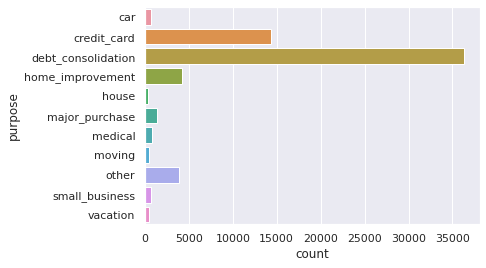

<AxesSubplot:xlabel='count', ylabel='emp_length'>

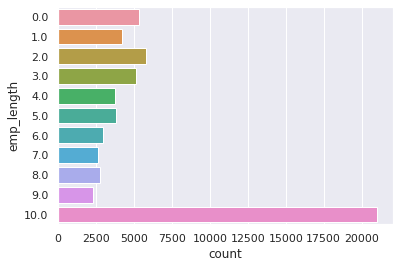

In [211]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [212]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [213]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

count    12325.000000
mean         0.335903
std          0.943011
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         25.000000
Name: delinq_2yrs, dtype: float64

count    51236.000000
mean         0.308143
std          0.867453
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         26.000000
Name: delinq_2yrs, dtype: float64

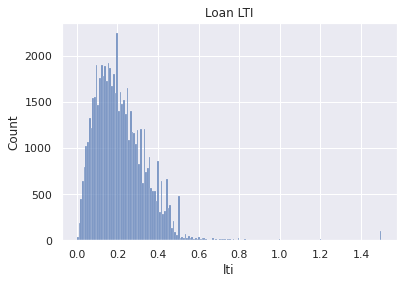

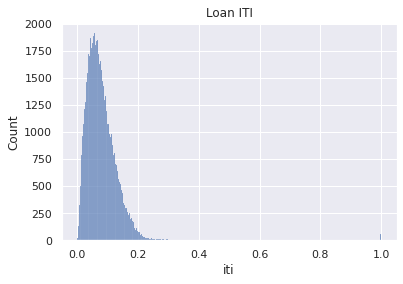

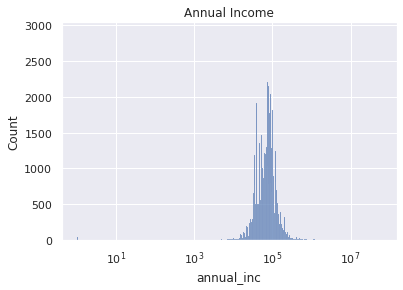

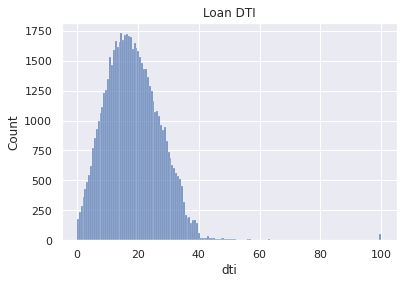

In [214]:
#sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
#plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()
sns.histplot(x='dti', data=df).set(title='Loan DTI')
plt.show()

In [215]:
df.dti.describe()

count    63525.000000
mean        18.495760
std          9.330262
min          0.000000
25%         11.880000
50%         17.760000
75%         24.340000
max        100.000000
Name: dti, dtype: float64

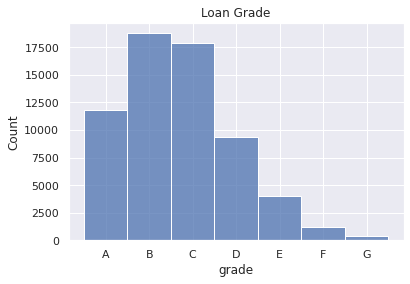

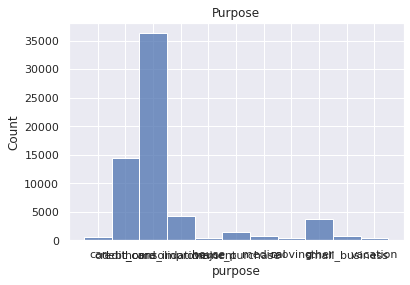

In [216]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')
plt.show()
sns.histplot(x='purpose', data=df).set(title='Purpose')
plt.show()

In [217]:
df.purpose.value_counts()

debt_consolidation    36295
credit_card           14389
home_improvement       4226
other                  3827
major_purchase         1419
medical                 786
small_business          706
car                     651
vacation                443
moving                  438
house                   381
Name: purpose, dtype: int64

### EDA with target

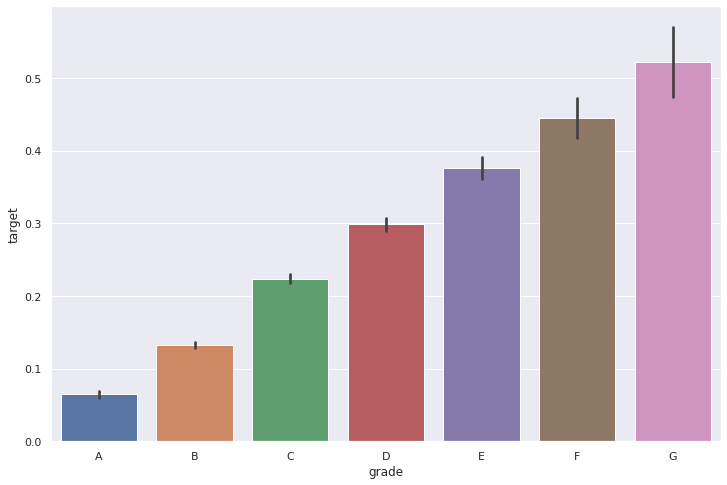

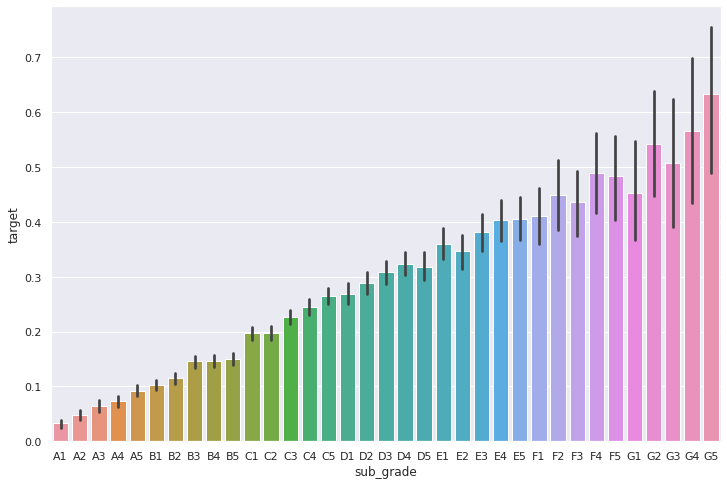

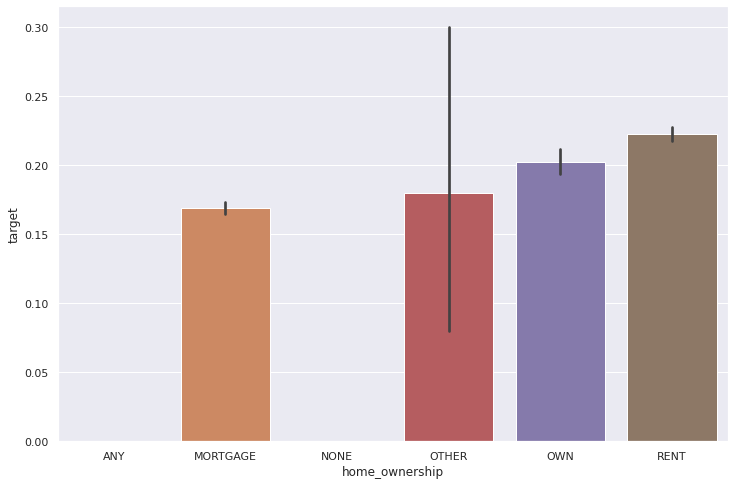

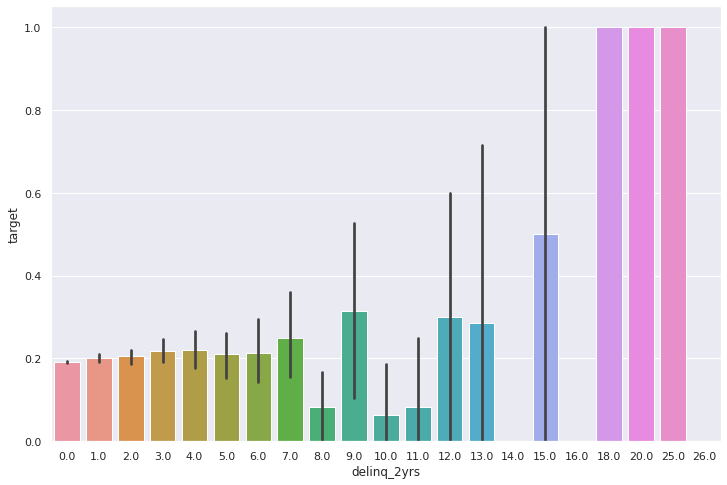

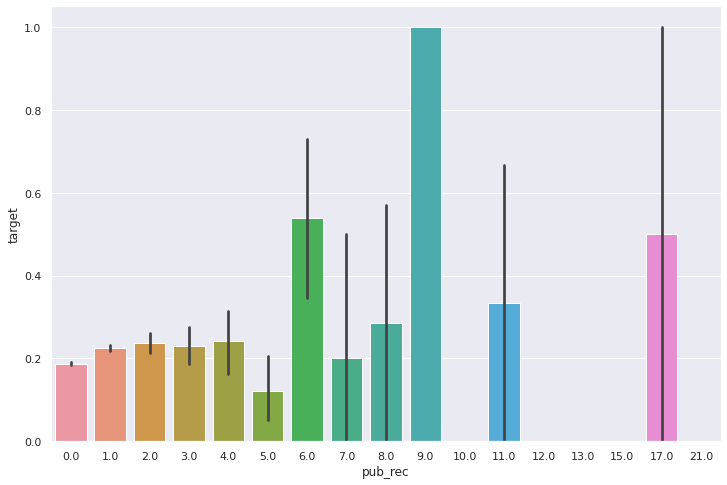

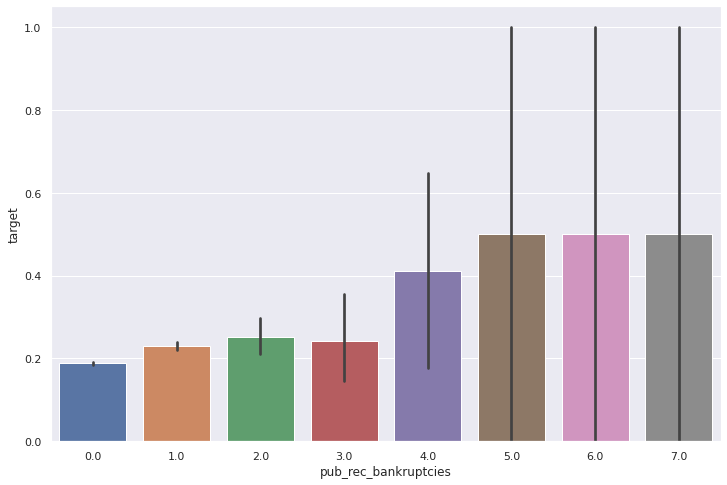

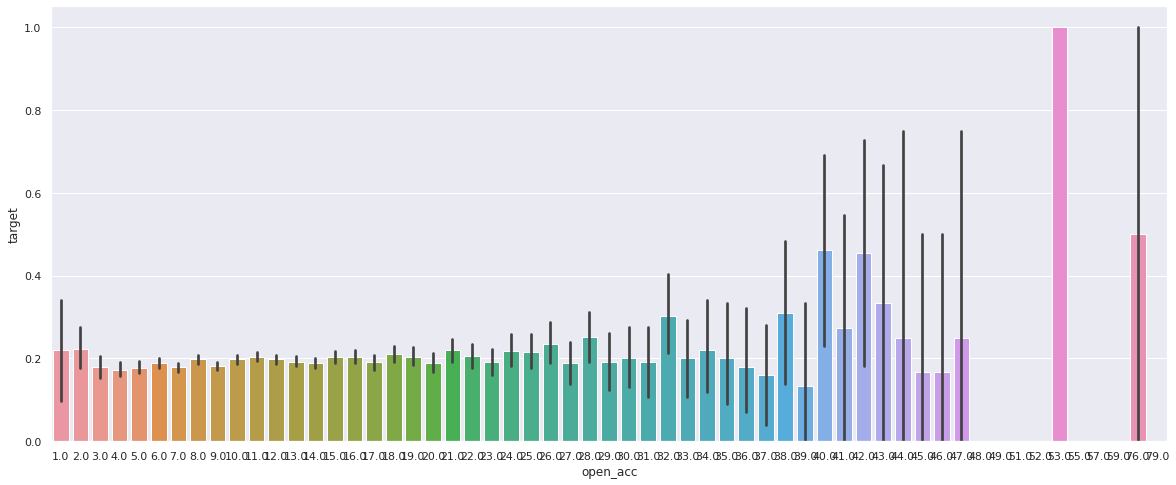

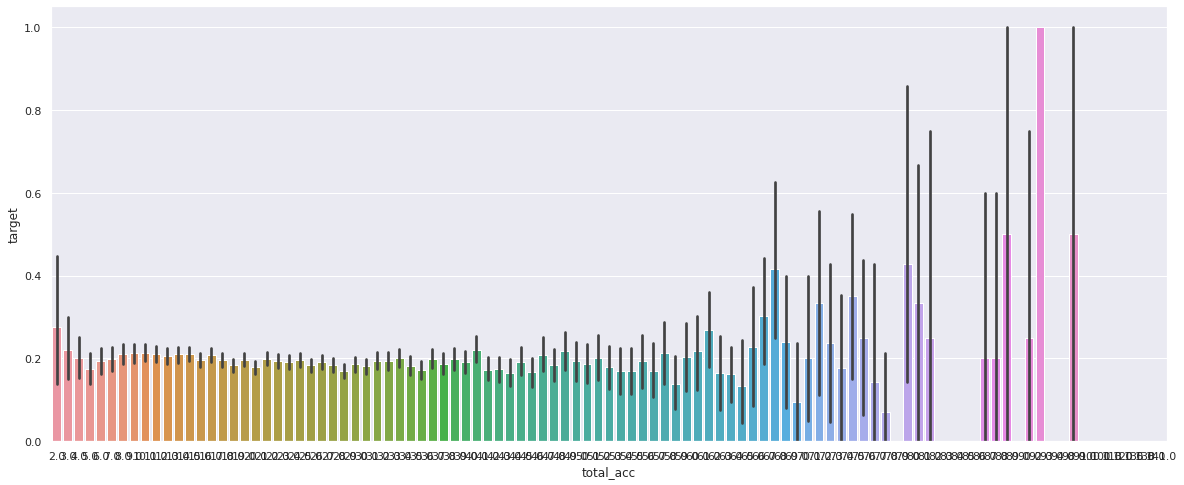

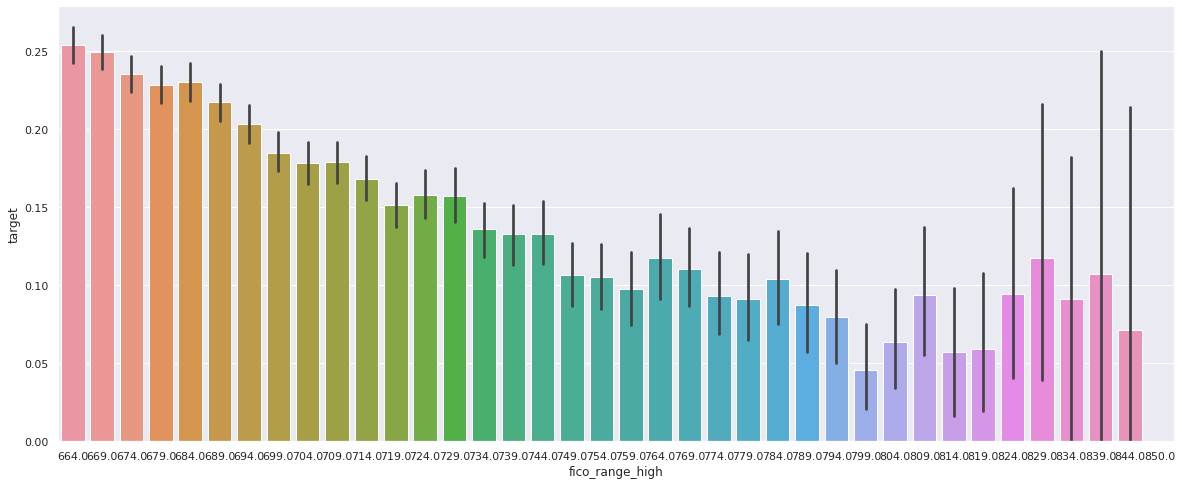

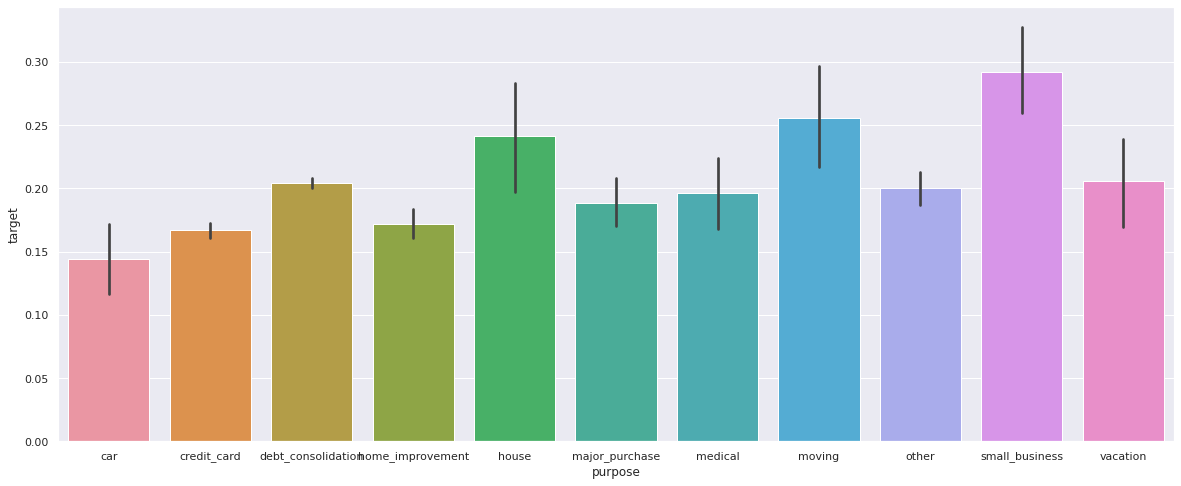

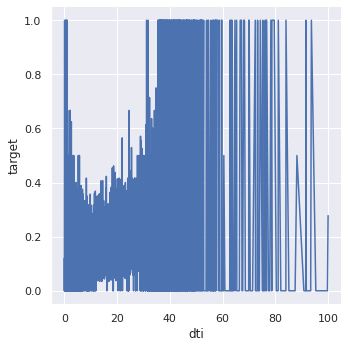

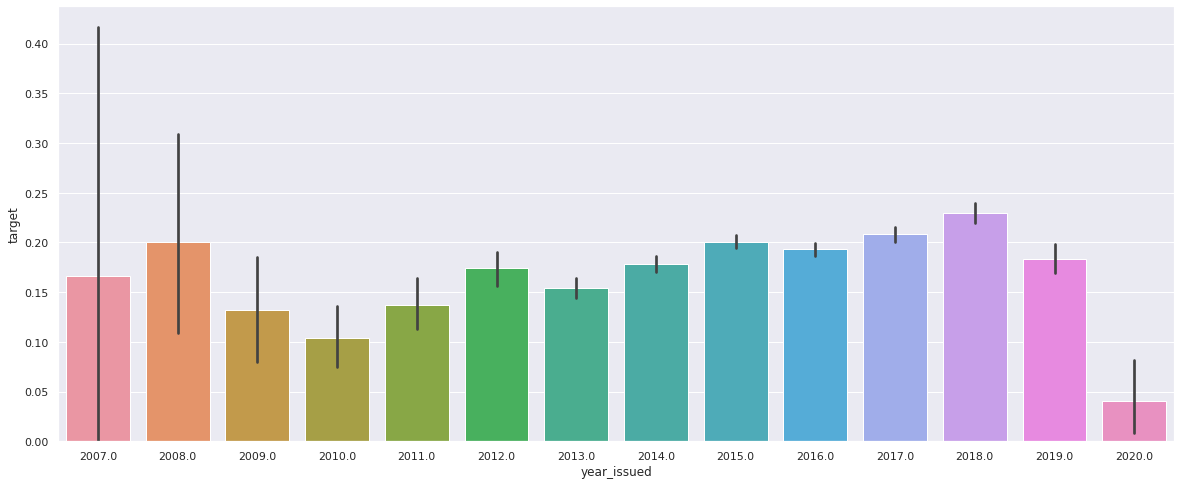

In [218]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()
sns.relplot(x='dti', y='target', data=df, ci=None, kind = 'line')
plt.show()
sns.barplot(x='year_issued', y='target', data=df)
plt.show()

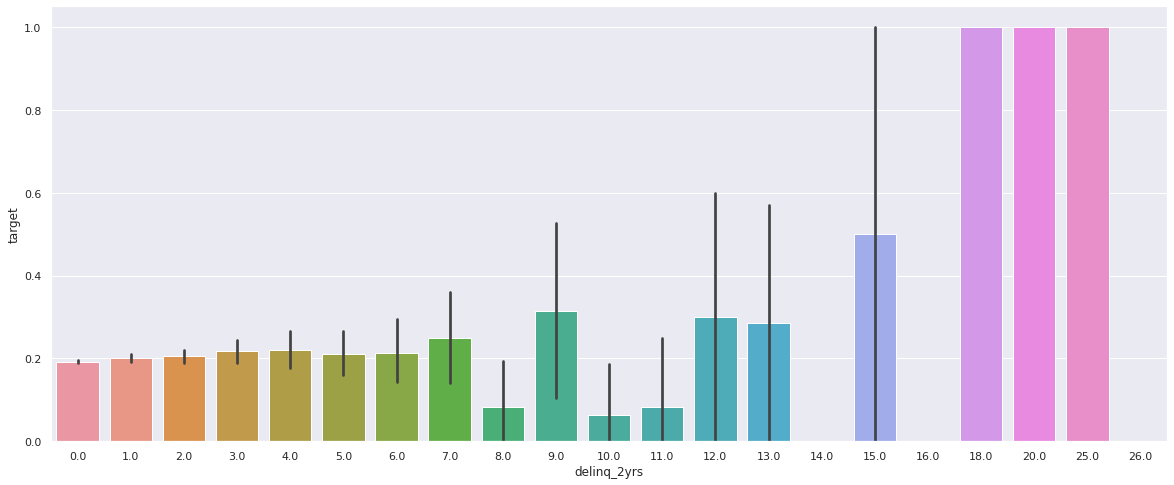

In [219]:
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()

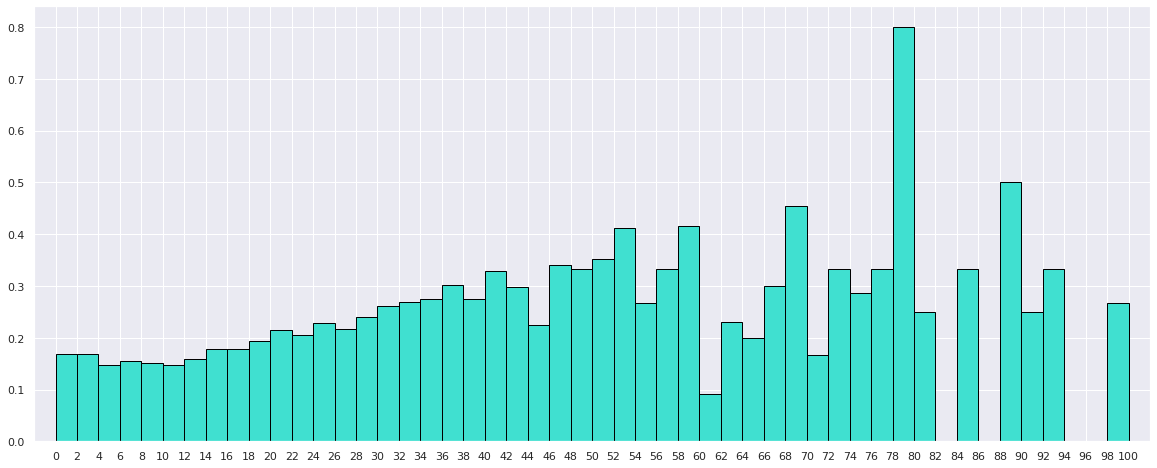

In [220]:
a = df.dti
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 51) # 10 bins, so 11 bin boundaries
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

### Train-test split, missing values

In [221]:
display(df.count())

loan_amnt                         63561
funded_amnt                       63561
funded_amnt_inv                   63561
term                              63561
int_rate                          63561
installment                       63561
purpose                           63561
title                             62787
initial_list_status               63561
application_type                  63561
grade                             63561
sub_grade                         63561
fico_range_high                   63561
emp_title                         59179
emp_length                        59632
home_ownership                    63561
annual_inc                        63561
zip_code                          63561
addr_state                        63561
dti                               63525
verification_status               63561
mo_sin_rcnt_tl                    63561
mths_since_last_delinq            63561
mths_since_last_major_derog       63561
mths_since_last_record            63561


In [222]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
features_fill_zero = ['open_rv_12m', 'open_il_12m', 'emp_length', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m']

for col in features_fill_zero:
    df[col] = df[col].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count(), test.count())

(57205, 77)

(6356, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,6000.0,6000.0,6000.0,36.0,11.80,198.720001,debt_consolidation,Debt consolidation,w,Individual,B,B4,709.0,MISSING,0.0,RENT,41800.0,41,ME,33.959999,Source Verified,18.0,23.0,1200.0,1200.0,23.0,23.0,0.0,1.0,0.0,1.0,7.0,1.0,0.0,15.0,4323.0,30258.0,5646.0,58.8,2354.0,47.0,2.0,4.0,9600.0,1.0,0.0,0.0,0.0,0.0,30258.0,0.0,0.0,33.299999,86.699997,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,12,2018,11.501947,0.0,0.0,0.143541,0.057049,0,0.135072,0.103421,0.723876,0.723876,0.229665,0,0.466667,0
1,8000.0,8000.0,8000.0,36.0,10.16,258.739990,debt_consolidation,Debt consolidation,f,Individual,B,B1,694.0,Bridgeton Board of Edu,3.0,RENT,48000.0,83,NJ,14.110000,Not Verified,8.0,10.0,10.0,1200.0,1200.0,13.0,1.0,1.0,0.0,0.0,24.0,5.0,0.0,35.0,1069.0,23519.0,6428.0,15.5,22029.0,8.0,13.0,21.0,41500.0,3.0,0.0,0.0,0.0,0.0,23519.0,0.0,0.0,0.000000,85.000000,0.0,0.0,2.0,0.0,0.0,2.0,2013.0,6,2013,14.499956,0.0,0.0,0.166667,0.064685,0,0.133917,0.022271,0.489979,0.489979,0.864583,0,0.685714,0
2,31300.0,31300.0,31300.0,60.0,20.80,843.260010,debt_consolidation,Pay off credit cards,w,Individual,E,E1,704.0,King County Prosecutor's Office,10.0,MORTGAGE,70000.0,980,WA,12.890000,Verified,29.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,1.0,0.0,0.0,5.0,0.0,7.0,17.0,6237.0,31186.0,31186.0,84.3,5743.0,29.0,5.0,5.0,37000.0,0.0,0.0,0.0,0.0,0.0,31186.0,0.0,0.0,75.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,9,2013,16.999665,0.0,0.0,0.447143,0.144559,0,0.445514,0.089100,0.445514,0.445514,0.528571,0,0.294118,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,1750.0,1750.0,1750.0,36.0,24.99,69.580002,debt_consolidation,debt pay off,f,Individual,F,F4,679.0,Direct care,4.0,RENT,29000.0,152,PA,16.059999,Not Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,0.0,5.0,5.0,0.0,7.0,3436.0,17181.0,5805.0,67.5,615.0,3.0,2.0,3.0,8600.0,0.0,0.0,0.0,0.0,0.0,17181.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,12,2013,4.249232,0.0,0.0,0.060345,0.028792,0,0.200172,0.118483,0.592448,0.592448,0.296552,0,0.714286,0
1,5050.0,5050.0,5050.0,36.0,7.84,157.880005,debt_consolidation,Debt consolidation,w,Individual,A,A4,709.0,Lead Cashier,1.0,RENT,20000.0,395,MS,14.830000,Source Verified,14.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,14.0,1547.0,9279.0,9279.0,63.1,4402.0,14.0,3.0,6.0,14700.0,0.0,0.0,0.0,0.0,0.0,9279.0,0.0,0.0,25.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,8,2018,14.582093,0.0,0.0,0.252500,0.094728,0,0.463950,0.077350,0.463950,0.463950,0.735000,0,0.428571,0
2,6250.0,6250.0,6250.0,36.0,16.02,219.800003,credit_card,Credit card refinancing,w,Individual,C,C5,714.0,MISSING,0.0,RENT,14220.0,181,PA,36.459999,Not Verified,17.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,9.0,2.0,0.0,11.0,1784.0,16053.0,16053.0,42.5,11677.0,17.0,8.0,9.0,37800.0,0.0,0.0,0.0,0.0,0.0,16053.0,0.0,0.0,40.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,9,2017,25.834891,0.0,1.0,0.439522,0.185485,0,1.128903,0.125457,1.128903,1.128903,2.658228,0,0.818182,0


loan_amnt                         57205
funded_amnt                       57205
funded_amnt_inv                   57205
term                              57205
int_rate                          57205
installment                       57205
purpose                           57205
title                             57205
initial_list_status               57205
application_type                  57205
grade                             57205
sub_grade                         57205
fico_range_high                   57205
emp_title                         57205
emp_length                        57205
home_ownership                    57205
annual_inc                        57205
zip_code                          57205
addr_state                        57205
dti                               57205
verification_status               57205
mo_sin_rcnt_tl                    57205
mths_since_last_delinq            57205
mths_since_last_major_derog       57205
mths_since_last_record            57205


loan_amnt                         6356
funded_amnt                       6356
funded_amnt_inv                   6356
term                              6356
int_rate                          6356
installment                       6356
purpose                           6356
title                             6356
initial_list_status               6356
application_type                  6356
grade                             6356
sub_grade                         6356
fico_range_high                   6356
emp_title                         6356
emp_length                        6356
home_ownership                    6356
annual_inc                        6356
zip_code                          6356
addr_state                        6356
dti                               6356
verification_status               6356
mo_sin_rcnt_tl                    6356
mths_since_last_delinq            6356
mths_since_last_major_derog       6356
mths_since_last_record            6356
mths_since_recent_bc_dlq 

### Categorical features encoding

In [223]:
# TE for categorical features

test00 = test.copy()
time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

freq_enc = (train.groupby('title').size()) / len(train)
train['title_fencoded'] = train['title'].apply(lambda x : freq_enc[x])
test['title_fencoded'] = test['title'].apply(lambda x : freq_enc[x])

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

32.12961149215698

2.080780506134033

(57205, 78)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,6000.0,6000.0,6000.0,36.0,11.80,198.720001,w,Individual,709.0,0.0,41800.0,33.959999,Source Verified,18.0,23.0,1200.0,1200.0,23.0,23.0,0.0,1.0,0.0,1.0,7.0,1.0,0.0,15.0,4323.0,30258.0,5646.0,58.8,2354.0,47.0,2.0,4.0,9600.0,1.0,0.0,0.0,0.0,0.0,30258.0,0.0,0.0,33.299999,86.699997,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,12,2018,11.501947,0.0,0.0,0.143541,0.057049,0,0.135072,0.103421,0.723876,0.723876,0.229665,0,0.466667,0,0.505218,0.142223,0.249138,0.203192,0.208236,0.137836,0.124201,0.132181,0.224116
1,8000.0,8000.0,8000.0,36.0,10.16,258.739990,f,Individual,694.0,3.0,48000.0,14.110000,Not Verified,8.0,10.0,10.0,1200.0,1200.0,13.0,1.0,1.0,0.0,0.0,24.0,5.0,0.0,35.0,1069.0,23519.0,6428.0,15.5,22029.0,8.0,13.0,21.0,41500.0,3.0,0.0,0.0,0.0,0.0,23519.0,0.0,0.0,0.000000,85.000000,0.0,0.0,2.0,0.0,0.0,2.0,2013.0,6,2013,14.499956,0.0,0.0,0.166667,0.064685,0,0.133917,0.022271,0.489979,0.489979,0.864583,0,0.685714,0,0.505218,0.106915,0.192970,0.203192,0.208236,0.220920,0.213289,0.132181,0.224116
2,31300.0,31300.0,31300.0,60.0,20.80,843.260010,w,Individual,704.0,10.0,70000.0,12.890000,Verified,29.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,1.0,0.0,0.0,5.0,0.0,7.0,17.0,6237.0,31186.0,31186.0,84.3,5743.0,29.0,5.0,5.0,37000.0,0.0,0.0,0.0,0.0,0.0,31186.0,0.0,0.0,75.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,9,2013,16.999665,0.0,0.0,0.447143,0.144559,0,0.445514,0.089100,0.445514,0.445514,0.528571,0,0.294118,0,0.000087,0.353593,0.192970,0.203192,0.244142,0.149003,0.165694,0.374099,0.166046
3,20000.0,20000.0,20000.0,36.0,12.49,668.979980,w,Individual,684.0,4.0,86000.0,17.219999,Not Verified,15.0,56.0,1200.0,1200.0,1200.0,56.0,0.0,0.0,0.0,0.0,12.0,4.0,3.0,32.0,13952.0,167427.0,18906.0,67.3,634.0,21.0,5.0,8.0,28100.0,0.0,0.0,0.0,0.0,0.0,47587.0,0.0,0.0,100.000000,96.800003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,4,2014,17.497964,0.0,0.0,0.232558,0.093346,0,0.219837,0.162233,1.946826,0.553337,0.326744,0,0.375000,0,0.505218,0.142223,0.191749,0.203192,0.208236,0.160262,0.193276,0.132181,0.166046
4,21000.0,21000.0,21000.0,36.0,7.97,657.780029,f,Individual,704.0,5.0,117000.0,30.010000,Source Verified,3.0,24.0,1200.0,1200.0,24.0,24.0,1.0,0.0,2.0,3.0,12.0,4.0,3.0,30.0,39504.0,474042.0,48979.0,65.6,11433.0,18.0,8.0,8.0,74700.0,0.0,0.0,0.0,0.0,0.0,154540.0,0.0,0.0,40.000000,96.699997,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,11,2017,23.587069,0.0,0.0,0.179487,0.067465,0,0.418624,0.337641,4.051641,1.320855,0.638462,0,0.400000,0,0.059068,0.085667,0.192970,0.165993,0.164929,0.242188,0.176806,0.064390,0.166046


loan_amnt                         57205
funded_amnt                       57205
funded_amnt_inv                   57205
term                              57205
int_rate                          57205
installment                       57205
initial_list_status               57205
application_type                  57205
fico_range_high                   57205
emp_length                        57205
annual_inc                        57205
dti                               57205
verification_status               57205
mo_sin_rcnt_tl                    57205
mths_since_last_delinq            57205
mths_since_last_major_derog       57205
mths_since_last_record            57205
mths_since_recent_bc_dlq          57205
mths_since_recent_revol_delinq    57205
num_tl_op_past_12m                57205
inq_last_6mths                    57205
inq_fi                            57205
inq_last_12m                      57205
open_acc                          57205
acc_open_past_24mths              55785


In [224]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,1750.0,1750.0,1750.0,36.0,24.99,69.580002,f,Individual,679.0,4.0,29000.0,16.059999,Not Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,0.0,5.0,5.0,0.0,7.0,3436.0,17181.0,5805.0,67.5,615.0,3.0,2.0,3.0,8600.0,0.0,0.0,0.0,0.0,0.0,17181.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,12,2013,4.249232,0.0,0.060345,0.028792,0,0.200172,0.118483,0.592448,0.592448,0.296552,0,0.714286,0,0.000035,0.474207,0.193759,0.204085,0.168837,0.149498,0.186727,0.446855,0.222345
1,5050.0,5050.0,5050.0,36.0,7.84,157.880005,w,Individual,709.0,1.0,20000.0,14.830000,Source Verified,14.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,14.0,1547.0,9279.0,9279.0,63.1,4402.0,14.0,3.0,6.0,14700.0,0.0,0.0,0.0,0.0,0.0,9279.0,0.0,0.0,25.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,8,2018,14.582093,0.0,0.252500,0.094728,0,0.463950,0.077350,0.463950,0.463950,0.735000,0,0.428571,0,0.505218,0.071931,0.193759,0.204085,0.209399,0.343118,0.258101,0.063120,0.222345
2,6250.0,6250.0,6250.0,36.0,16.02,219.800003,w,Individual,714.0,0.0,14220.0,36.459999,Not Verified,17.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,9.0,2.0,0.0,11.0,1784.0,16053.0,16053.0,42.5,11677.0,17.0,8.0,9.0,37800.0,0.0,0.0,0.0,0.0,0.0,16053.0,0.0,0.0,40.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,9,2017,25.834891,0.0,0.439522,0.185485,0,1.128903,0.125457,1.128903,1.128903,2.658228,0,0.818182,0,0.200892,0.264703,0.254215,0.166913,0.171883,0.264263,0.186727,0.222982,0.222345
3,15000.0,15000.0,15000.0,60.0,9.44,314.589996,w,Individual,799.0,2.0,120000.0,6.790000,Not Verified,14.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,1.0,0.0,10.0,6.0,1.0,16.0,32312.0,323116.0,8666.0,20.3,28834.0,20.0,2.0,7.0,42700.0,0.0,0.0,0.0,0.0,0.0,18236.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,7,2017,14.831242,0.0,0.125000,0.031459,0,0.072217,0.269267,2.692633,0.151967,0.355833,0,0.625000,0,0.200892,0.103727,0.245545,0.166913,0.171883,0.259854,0.206128,0.132532,0.168627
4,12000.0,12000.0,11950.0,36.0,16.29,423.609985,f,Individual,694.0,6.0,72900.0,1.320000,Not Verified,7.0,44.0,1200.0,1200.0,44.0,44.0,3.0,0.0,0.0,0.0,4.0,3.0,4.0,9.0,55196.0,220782.0,2799.0,71.8,516.0,7.0,2.0,2.0,3900.0,0.0,0.0,0.0,0.0,0.0,2799.0,0.0,0.0,100.0,77.0,0.0,0.0,0.0,0.0,0.0,1.0,2013.0,4,2013,18.333025,0.0,0.164609,0.069730,0,0.038395,0.757147,3.028560,0.038395,0.053498,0,0.444444,0,0.059068,0.243839,0.193759,0.171724,0.171133,0.184484,0.190547,0.222982,0.168627


Number of features before transaformation:  (57205, 77)
time to do feature proprocessing:  2.3844854831695557
Number of features after transaformation:  (57205, 79)


,cat__verification_status_Not Verified,cat__verification_status_Source Verified,cat__verification_status_Verified,cat__initial_list_status_w,cat__application_type_Joint App,remainder__loan_amnt,remainder__funded_amnt,remainder__funded_amnt_inv,remainder__term,remainder__int_rate,remainder__installment,remainder__fico_range_high,remainder__emp_length,remainder__annual_inc,remainder__dti,remainder__mo_sin_rcnt_tl,remainder__mths_since_last_delinq,remainder__mths_since_last_major_derog,remainder__mths_since_last_record,remainder__mths_since_recent_bc_dlq,remainder__mths_since_recent_revol_delinq,remainder__num_tl_op_past_12m,remainder__inq_last_6mths,remainder__inq_fi,remainder__inq_last_12m,remainder__open_acc,remainder__acc_open_past_24mths,remainder__mort_acc,remainder__total_acc,remainder__avg_cur_bal,remainder__tot_cur_bal,remainder__revol_bal,remainder__revol_util,remainder__bc_open_to_buy,remainder__mo_sin_rcnt_rev_tl_op,remainder__num_actv_rev_tl,remainder__num_op_rev_tl,remainder__total_rev_hi_lim,remainder__delinq_2yrs,remainder__acc_now_delinq,remainder__delinq_amnt,remainder__pub_rec,remainder__pub_rec_bankruptcies,remainder__total_bal_ex_mort,remainder__tot_coll_amt,remainder__tax_liens,remainder__percent_bc_gt_75,remainder__pct_tl_nvr_dlq,remainder__open_rv_12m,remainder__open_il_12m,remainder__num_tl_90g_dpd_24m,remainder__num_tl_30dpd,remainder__num_tl_120dpd_2m,remainder__num_accts_ever_120_pd,remainder__year_issued,remainder__month_issued,remainder__year_earliest,remainder__years_borrowing,remainder__pub_rec_pa,remainder__lti,remainder__iti,remainder__joint,remainder__revol_balance_income,remainder__avg_cur_bal_inc,remainder__tot_cur_bal_inc,remainder__total_bal_ex_mort_inc,remainder__total_rev_inc,remainder__low_fico,remainder__open_cl_ratio,remainder__was_bankrupt,remainder__title_fencoded,remainder__sub_grade_encoded,remainder__emp_title_encoded,remainder__purpose_encoded,remainder__title_encoded,remainder__zip_code_encoded,remainder__addr_state_encoded,remainder__grade_encoded,remainder__home_ownership_encoded
0,0.0,1.0,0.0,1.0,0.0,6000.0,6000.0,6000.0,36.0,11.80,198.720001,709.0,0.0,41800.0,33.959999,18.0,23.0,1200.0,1200.0,23.0,23.0,0.0,1.0,0.0,1.0,7.0,1.0,0.0,15.0,4323.0,30258.0,5646.0,58.8,2354.0,47.0,2.0,4.0,9600.0,1.0,0.0,0.0,0.0,0.0,30258.0,0.0,0.0,33.299999,86.699997,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,12.0,2018.0,11.501947,0.0,0.143541,0.057049,0.0,0.135072,0.103421,0.723876,0.723876,0.229665,0.0,0.466667,0.0,0.505218,0.142223,0.249138,0.203192,0.208236,0.137836,0.124201,0.132181,0.224116
1,1.0,0.0,0.0,0.0,0.0,8000.0,8000.0,8000.0,36.0,10.16,258.739990,694.0,3.0,48000.0,14.110000,8.0,10.0,10.0,1200.0,1200.0,13.0,1.0,1.0,0.0,0.0,24.0,5.0,0.0,35.0,1069.0,23519.0,6428.0,15.5,22029.0,8.0,13.0,21.0,41500.0,3.0,0.0,0.0,0.0,0.0,23519.0,0.0,0.0,0.000000,85.000000,0.0,0.0,2.0,0.0,0.0,2.0,2013.0,6.0,2013.0,14.499956,0.0,0.166667,0.064685,0.0,0.133917,0.022271,0.489979,0.489979,0.864583,0.0,0.685714,0.0,0.505218,0.106915,0.192970,0.203192,0.208236,0.220920,0.213289,0.132181,0.224116
2,0.0,0.0,1.0,1.0,0.0,31300.0,31300.0,31300.0,60.0,20.80,843.260010,704.0,10.0,70000.0,12.890000,29.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,1.0,0.0,0.0,5.0,0.0,7.0,17.0,6237.0,31186.0,31186.0,84.3,5743.0,29.0,5.0,5.0,37000.0,0.0,0.0,0.0,0.0,0.0,31186.0,0.0,0.0,75.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,9.0,2013.0,16.999665,0.0,0.447143,0.144559,0.0,0.445514,0.089100,0.445514,0.445514,0.528571,0.0,0.294118,0.0,0.000087,0.353593,0.192970,0.203192,0.244142,0.149003,0.165694,0.374099,0.166046
3,1.0,0.0,0.0,1.0,0.0,20000.0,20000.0,20000.0,36.0,12.49,668.979980,684.0,4.0,86000.0,17.219999,15.0,56.0,1200.0,1200.0,1200.0,56.0,0.0,0.0,0.0,0.0,12.0,4.0,3.0,32.0,13952.0,167427.0,18906.0,67.3,634.0,21.0,5.0,8.0,28100.0,0.0,0.0,0.0,0.0,0.0,47587.0,0.0,0.0,100.000000,96.800003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,4.0,2014.0,17.497964,0.0,0.232558,0.093346,0.0,0.219837,0.162233,1.946826,0.553337,0.326744,0.0,0.375000,0.0,0.505218,0.142223,0.191749

### Modeling

'Train Accuracy: '

0.8682807446901495

'F1 score: '

0.5091524982085857

'ROCAUC: '

0.6723982115329336

'PRAUC: '

0.7700632028821167

'R20P: '

0.9770925110132158

'Test Accuracy: '

0.80254877281309

'F1 score: '

0.20012746972594012

'ROCAUC: '

0.546539896639972

'PRAUC: '

0.3593211316854921

'R20P: '

0.42346938775510207

1.6488895416259766

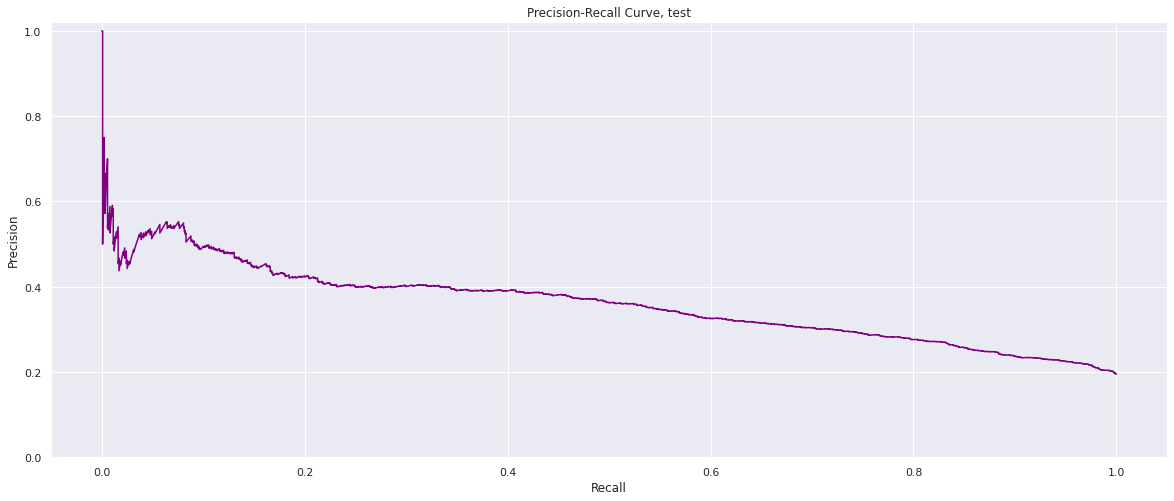

In [225]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

[I 2022-08-13 16:10:43,594] A new study created in memory with name: no-name-b204ac9b-5d46-4d4b-8092-e742c24c1054
[I 2022-08-13 16:10:45,615] Trial 0 finished with value: 0.36130660837052997 and parameters: {'n_estimators': 309, 'max_depth': 3, 'learning_rate': 0.27202325178881864, 'colsample_bytree': 0.4309854654807509, 'subsample': 0.7936100416948901, 'alpha': 7.93848285983526, 'lambda': 17.699404384200996, 'gamma': 3.4720271421317576e-06, 'min_child_weight': 2.394958409627292}. Best is trial 0 with value: 0.36130660837052997.
[I 2022-08-13 16:10:49,461] Trial 1 finished with value: 0.3786229060971801 and parameters: {'n_estimators': 878, 'max_depth': 2, 'learning_rate': 0.06552016802639551, 'colsample_bytree': 0.8981915476924124, 'subsample': 0.5014693315429111, 'alpha': 5.639309022767767, 'lambda': 1.3336108113503364, 'gamma': 0.000177712639378863, 'min_child_weight': 0.4991623574533809}. Best is trial 1 with value: 0.3786229060971801.
[I 2022-08-13 16:10:52,556] Trial 2 finished w

Total time for hypermarameter optimization  222.53412866592407
        n_estimators : 778
           max_depth : 5
       learning_rate : 0.01232991447259318
    colsample_bytree : 0.7818452309578046
           subsample : 0.6824106875614009
               alpha : 0.23356817990844517
              lambda : 7.126637769594665
               gamma : 0.00013986845544721927
    min_child_weight : 0.6710228647618028
best objective value : 0.3796643816973082


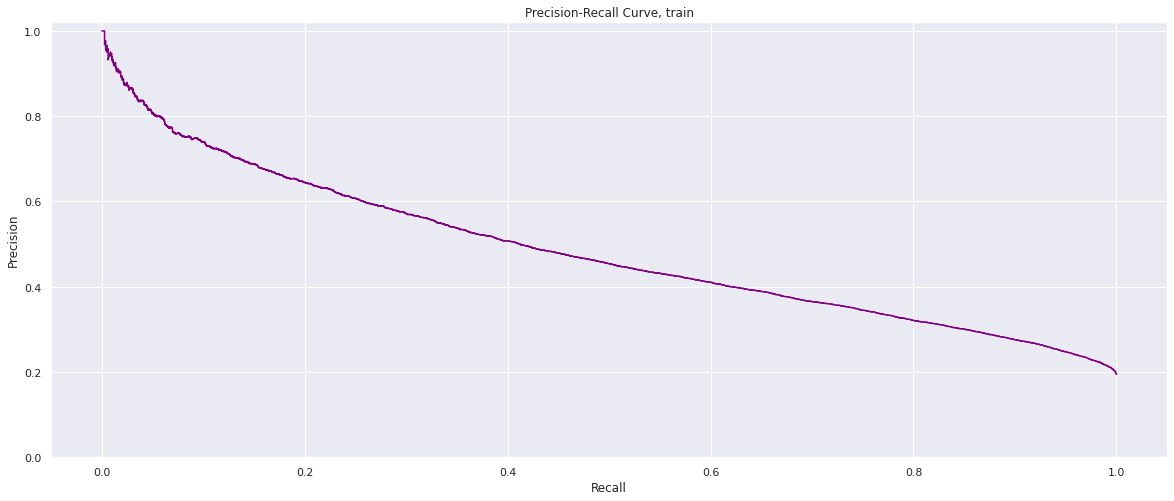

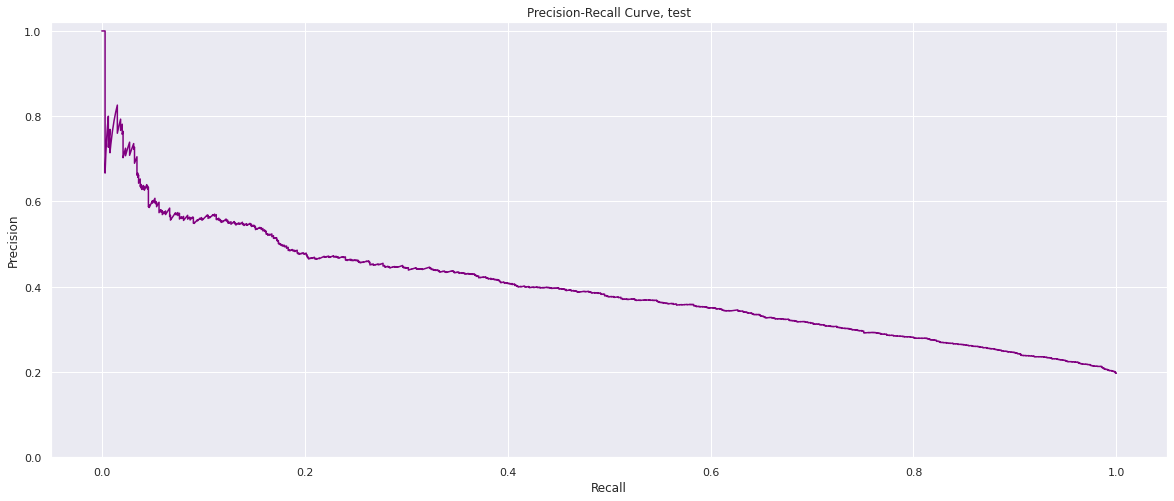

'Train Accuracy: '

0.8190717594615855

'F1 score: '

0.18362517747278753

'ROCAUC: '

0.5478464689374696

'PRAUC: '

0.48474332550284327

'R20P: '

0.644250363901019

'Test Accuracy: '

0.8082127123977344

'F1 score: '

0.13238434163701068

'ROCAUC: '

0.5305294109770209

'PRAUC: '

0.39440686421185667

'R20P: '

0.47438330170777987

230.15141224861145

In [226]:
### Fit XGBoost using Optuna hyperparameter optimization ###

time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=2):

    cv_regularizer=0.01
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.3),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict_proba(X_B)[:, 1]
            #y_pred_train[train_index] += model.predict_proba(X_A)[:, 1]
                      
        #precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred_train)
        #score_train = auc(recall_t, precision_t)
        precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred)
        score_test = auc(recall_t, precision_t)
            
        #score_train = roc_auc_score(y_train, y_pred_train)
        #score_test = roc_auc_score(y_train, y_pred) 
        #overfit = score_train-score_test
        #temp_out.append(score_test-cv_regularizer*overfit)
        temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

In [227]:
results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
fi = fi.sort_values('FI', ascending = False)

display(fi)

,col,FI
8,remainder__term,1.384519e-03
54,remainder__year_issued,1.006923e-03
71,remainder__sub_grade_encoded,8.181246e-04
65,remainder__total_bal_ex_mort_inc,5.978603e-04
9,remainder__int_rate,5.034613e-04
59,remainder__lti,5.034613e-04
12,remainder__emp_length,4.719950e-04
17,remainder__mths_since_last_major_derog,4.719950e-04
22,remainder__inq_last_6mths,4.090623e-04
32,remainder__revol_util,3.146633e-04


,col_name,feature_importance_vals
71,remainder__sub_grade_encoded,0.326226
8,remainder__term,0.150638
14,remainder__dti,0.103826
9,remainder__int_rate,0.098655
26,remainder__acc_open_past_24mths,0.081973
72,remainder__emp_title_encoded,0.075193
54,remainder__year_issued,0.070686
59,remainder__lti,0.068887
78,remainder__home_ownership_encoded,0.058205
35,remainder__num_actv_rev_tl,0.048817


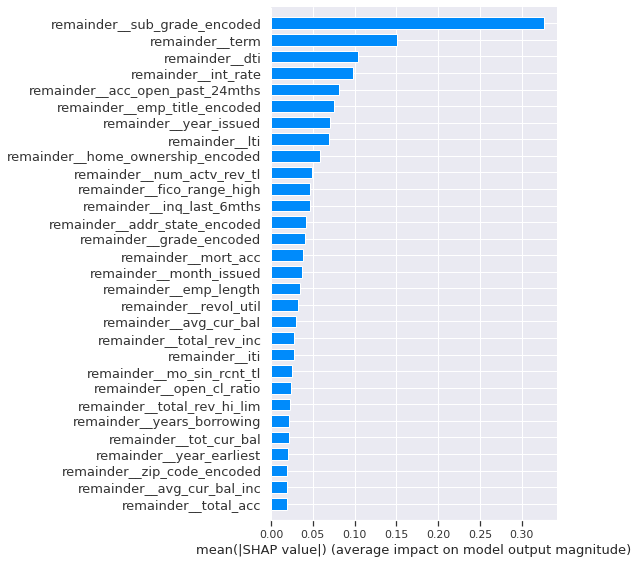

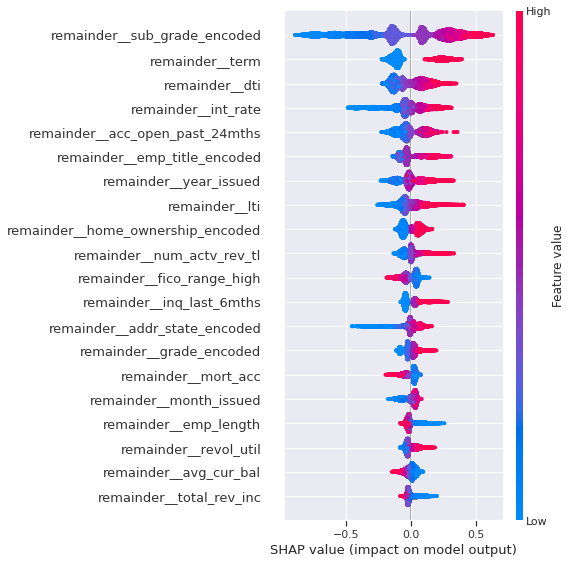

In [228]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
display(feature_importance)

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)

shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [229]:
# error analysis
y_pred = optuna_xgb.predict_proba(X_test)[:, 1]
error_df = test00.copy()
error_df['truth'] = y_test
error_df['pred'] = y_pred
error_df['error'] = error_df.pred - error_df.truth
error_df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,truth,pred,error
0,1750.0,1750.0,1750.0,36.0,24.99,69.580002,debt_consolidation,debt pay off,f,Individual,F,F4,679.0,Direct care,4.0,RENT,29000.0000,152,PA,16.059999,Not Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,0.0,5.0,5.0,0.0,7.0,3436.0,17181.0,5805.0,67.5,615.0,3.0,2.0,3.0,8600.0,0.0,0.0,0.0,0.0,0.0,17181.0,0.0,0.0,100.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2013.0,12,2013,4.249232,0.000000,0.0,0.060345,0.028792,0,0.200172,0.118483,0.592448,0.592448,0.296552,0,0.714286,0,0.0,0.182829,0.182829
1,5050.0,5050.0,5050.0,36.0,7.84,157.880005,debt_consolidation,Debt consolidation,w,Individual,A,A4,709.0,Lead Cashier,1.0,RENT,20000.0000,395,MS,14.830000,Source Verified,14.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,14.0,1547.0,9279.0,9279.0,63.1,4402.0,14.0,3.0,6.0,14700.0,0.0,0.0,0.0,0.0,0.0,9279.0,0.0,0.0,25.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2018.0,8,2018,14.582093,0.000000,0.0,0.252500,0.094728,0,0.463950,0.077350,0.463950,0.463950,0.735000,0,0.428571,0,0.0,0.130098,0.130098
2,6250.0,6250.0,6250.0,36.0,16.02,219.800003,credit_card,Credit card refinancing,w,Individual,C,C5,714.0,MISSING,0.0,RENT,14220.0000,181,PA,36.459999,Not Verified,17.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,9.0,2.0,0.0,11.0,1784.0,16053.0,16053.0,42.5,11677.0,17.0,8.0,9.0,37800.0,0.0,0.0,0.0,0.0,0.0,16053.0,0.0,0.0,40.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,9,2017,25.834891,0.000000,1.0,0.439522,0.185485,0,1.128903,0.125457,1.128903,1.128903,2.658228,0,0.818182,0,1.0,0.295074,-0.704926
3,15000.0,15000.0,15000.0,60.0,9.44,314.589996,credit_card,Credit card refinancing,w,Individual,B,B1,799.0,Production manager,2.0,MORTGAGE,120000.0000,330,FL,6.790000,Not Verified,14.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,1.0,0.0,10.0,6.0,1.0,16.0,32312.0,323116.0,8666.0,20.3,28834.0,20.0,2.0,7.0,42700.0,0.0,0.0,0.0,0.0,0.0,18236.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,7,2017,14.831242,0.000000,0.0,0.125000,0.031459,0,0.072217,0.269267,2.692633,0.151967,0.355833,0,0.625000,0,0.0,0.091381,0.091381
4,12000.0,12000.0,11950.0,36.0,16.29,423.609985,home_improvement,Home improvement,f,Individual,C,C4,694.0,UniversalPegasus,6.0,MORTGAGE,72900.0000,774,TX,1.320000,Not Verified,7.0,44.0,1200.0,1200.0,44.0,44.0,3.0,0.0,0.0,0.0,4.0,3.0,4.0,9.0,55196.0,220782.0,2799.0,71.8,516.0,7.0,2.0,2.0,3900.0,0.0,0.0,0.0,0.0,0.0,2799.0,0.0,0.0,100.000000,77.000000,0.0,0.0,0.0,0.0,0.0,1.0,2013.0,4,2013,18.333025,0.000000,0.0,0.164609,0.069730,0,0.038395,0.757147,3.028560,0.038395,0.053498,0,0.444444,0,0.0,0.120993,0.120993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6351,27650.0,27650.0,2

In [230]:
display(error_df[['truth', 'pred']].describe(),error_df[error_df.error>0.8])

,truth,pred
count,6356.000000,6356.000000
mean,0.195249,0.191809
std,0.396423,0.124571
min,0.000000,0.017857
25%,0.000000,0.095883
50%,0.000000,0.163275
75%,0.000000,0.258945
max,1.000000,0.745997


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,truth,pred,error


In [231]:
error_df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,fico_range_high,emp_length,annual_inc,zip_code,dti,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,truth,pred,error
count,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6187.000000,6356.000000,6356.000000,6111.000000,6.111000e+03,6356.000000,6356.000000,6117.000000,6111.000000,6111.000000,6111.000000,6111.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6187.000000,6111.000000,6356.000000,6116.000000,6111.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6111.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6111.000000,6111.000000,6187.000000,6111.000000,6356.0,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000
mean,14472.766602,14464.400391,14443.800781,42.067967,13.120368,436.054779,701.312012,5.631372,75921.851562,507.834330,18.530045,12.316709,640.900879,898.125854,1011.521240,933.050354,816.200256,2.056482,0.626967,0.574103,1.204216,11.590780,4.621626,1.601164,24.610603,13375.565430,1.396048e+05,16060.999023,50.511861,10711.657227,13.408116,5.628048,8.298151,33333.648438,0.306010,0.003461,16.013531,0.211296,0.132001,49340.472656,242.528061,0.051605,43.447857,94.277748,0.727187,0.387665,0.084330,0.002360,0.000629,0.502536,2015.595500,6.446350,2015.595500,16.322899,0.014481,0.195249,0.217849,0.080621,0.034770,8.163054,4.072000,46.086102,44.376709,18.590504,0.0,0.509523,0.123663,0.195249,0.191809,-0.003439
std,8791.961914,8786.935547,8783.904297,10.432071,4.802094,260.993988,32.615105,3.862941,48910.035156,311.736061,9.376181,23.131958,582.516602,507.892822,420.988586,488.356873,547.349487,1.878477,0.918773,1.222018,2.108800,5.520587,3.193593,1.917494,12.157045,16270.855469,1.555307e+05,20086.371094,24.370638,15478.559570,15.944463,3.341098,4.645692,31943.892578,0.868344,0.063869,680.267273,0.568409,0.367921,46576.007812,2184.260254,0.367241,36.237675,8.722045,1.340933,0.774576,0.512134,0.054628,0.025080,1.330106,1.847235,3.425702,1.847235,7.557408,0.046437,0.396423,0.137686,0.060555,0.183212,403.216949,177.099411,2006.298706,1993.953491,722.695740,0.0,0.177037,0.329222,0.396423,0.124571,0.374569
min,1000.000000,1000.000000,0.000000,36.000000,5.310000,31.040001,664.000000,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2007.000000,1.000000,2007.000000,3.085621,0.000000,0.000000,0.005158,0.002085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.074074,0.000000,0.000000,0.017857,-0.973946
25%,7900.000000,7900.000000,7800.000000,36.000000,9.490000,246.582497,674.000000,2.000000,46000.000000,230.000000,11.830000,3.000000,

In [232]:
display(error_df[['truth', 'pred']].describe(),error_df[error_df.error<-0.95])

,truth,pred
count,6356.000000,6356.000000
mean,0.195249,0.191809
std,0.396423,0.124571
min,0.000000,0.017857
25%,0.000000,0.095883
50%,0.000000,0.163275
75%,0.000000,0.258945
max,1.000000,0.745997


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,truth,pred,error
398,21450.0,21450.0,21450.0,36.0,6.49,657.330017,debt_consolidation,Debt consolidation,w,Individual,A,A2,774.0,Manager,10.0,MORTGAGE,64000.0,403,KY,16.440001,Source Verified,11.0,1200.0,1200.0,1200.0,1200.0,1200.0,1.0,1.0,0.0,0.0,10.0,1.0,4.0,18.0,21656.0,173246.0,19138.0,32.9,35652.0,11.0,6.0,8.0,58100.0,0.0,0.0,0.0,0.0,0.0,32451.0,0.0,0.0,20.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,2,2015,27.338001,0.000000,1.0,0.335156,0.123249,0,0.299031,0.338375,2.706969,0.507047,0.907812,0,0.555556,0,1.0,0.034658,-0.965342
545,24000.0,24000.0,24000.0,36.0,6.92,740.179993,debt_consolidation,Debt consolidation,w,Individual,A,A4,739.0,Transaction Advisor,10.0,MORTGAGE,125000.0,453,OH,16.709999,Source Verified,11.0,30.0,1200.0,1200.0,1200.0,1200.0,1.0,0.0,0.0,0.0,13.0,3.0,7.0,36.0,35885.0,466501.0,86616.0,41.3,20158.0,11.0,3.0,9.0,119400.0,0.0,0.0,0.0,0.0,0.0,159981.0,0.0,0.0,0.000000,97.099998,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,4,2015,15.918191,0.000000,1.0,0.192000,0.071057,0,0.692928,0.287080,3.732008,1.279848,0.955200,0,0.361111,0,1.0,0.026054,-0.973946
657,10000.0,10000.0,10000.0,36.0,7.89,312.859985,debt_consolidation,Debt consolidation,w,Individual,A,A5,669.0,Delivery driver,8.0,MORTGAGE,45000.0,950,CA,11.490000,Verified,7.0,1200.0,1200.0,58.0,1200.0,1200.0,1.0,0.0,1.0,2.0,10.0,6.0,2.0,21.0,38046.0,304368.0,6050.0,35.8,9450.0,7.0,4.0,7.0,16900.0,0.0,0.0,0.0,1.0,1.0,17008.0,0.0,0.0,20.000000,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,2016.0,3,2016,14.749105,0.067801,1.0,0.222222,0.083429,0,0.134444,0.845467,6.763733,0.377956,0.375556,0,0.476190,1,1.0,0.045615,-0.954385
817,3600.0,3600.0,3600.0,36.0,7.35,111.739998,other,Other,w,Individual,A,A4,739.0,Business Aplication Specialist,10.0,MORTGAGE,57000.0,547,WI,21.920000,Not Verified,17.0,53.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,3.0,0.0,9.0,3.0,1.0,38.0,14012.0,112097.0,6318.0,60.2,3593.0,41.0,3.0,4.0,10500.0,0.0,0.0,0.0,0.0,0.0,28902.0,0.0,0.0,50.000000,97.400002,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,12,2017,21.500784,0.000000,1.0,0.063158,0.023524,0,0.110842,0.245825,1.966614,0.507053,0.184211,0,0.236842,0,1.0,0.042293,-0.957707
1052,19500.0,19500.0,19475.0,36.0,6.08,593.940002,credit_card,Credit card refinancing,f,Individual,A,A2,714.0,Park Host,6.0,MORTGAGE,61200.0,973,OR,14.000000,Not Verified,2.0,1200.0,1200.0,1200.0,1200.0,1200.0,4.0,1.0,0.0,1.0,8.0,9.0,0.0,26.0,17060.0,136481.0,19226.0,42.1,22529.0,4.0,5.0,6.0,45700.0,0.0,0.0,0.0,0.0,0.0,136481.0,0.0,0.0,0.000000,100.000000,2.0,2.0,0.0,0.0,0.0,0.0,2018.0,1,2018,13.670370,0.000000,1.0,0.318627,0.116459,0,0.314150,0.278758,2.230082,2.230082,0.746732,0,0.307692,0,1.0,0.037924,-0.962076
2263,10000.0,10000.0,10000.0,36.0,6.49,306.450012,other,Other,w,Individual,A,A2,789.0,MISSING,0.0,MORTGAGE,90000.0,902,CA,12.520000,Source Verified,4.0,1200.0,1200.0,1200.0,1200.0,1200.0,2.0,0.0,0.0,0.0,18.0,7.0,7.0,53.0,1555.0,27996.0,8949.0,8.8,50293.0,13.0,6.0,17.0,102200.0,0.0,0.0,0.0,0.0,0.0,27996.

In [233]:
#indx = 9506
#fig = plt.subplots(figsize=(6,6),dpi=200)
#ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")

In [234]:
#shap.initjs()
#shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

In [235]:
error_df[['pred','truth']].describe()

,pred,truth
count,6356.000000,6356.000000
mean,0.191809,0.195249
std,0.124571,0.396423
min,0.017857,0.000000
25%,0.095883,0.000000
50%,0.163275,0.000000
75%,0.258945,0.000000
max,0.745997,1.000000


In [236]:
display(error_df.groupby('year_issued').error.mean())
display(error_df.groupby('term').error.mean())
display(error_df.groupby('grade').error.mean())
display(error_df.groupby('purpose').error.mean())


year_issued
2007.0    0.134501
2008.0   -0.139253
2009.0    0.028773
2010.0    0.007731
2011.0   -0.015869
2012.0    0.009968
2013.0    0.014989
2014.0    0.007782
2015.0   -0.000804
2016.0   -0.005127
2017.0   -0.013152
2018.0   -0.009103
2019.0   -0.024268
2020.0   -0.013373
Name: error, dtype: float64

term
36.0    0.001371
60.0   -0.017654
Name: error, dtype: float64

grade
A   -0.015411
B   -0.000711
C   -0.007574
D    0.010050
E   -0.006560
F    0.039964
G   -0.013674
Name: error, dtype: float64

purpose
car                   0.007210
credit_card           0.006244
debt_consolidation   -0.007854
home_improvement      0.003121
house                 0.105914
major_purchase       -0.001737
medical              -0.015505
moving               -0.094307
other                -0.005362
small_business       -0.038190
vacation              0.047775
Name: error, dtype: float64

In [237]:
time.time()-time0

319.1380343437195